### Transcribing legato slurs from hard onset detection and ScoreCloud

In [159]:
# Autoload libraries
%load_ext autoreload
%autoreload 2

# External libraries
import os
import re
import pickle
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
import madmom
import mir_eval
from IPython.display import Audio
from music21 import *

# Pre- and postprocessing
from modules.analysis_funcs import get_segmented_data, get_test_peaks, aubio_peakpicker_do
# Dataset handler
from datasets import Dataset
# Model
from models import FINAL_MODEL_PATH
# Visualization functions
from modules.vis import onset_visualizer, passage_extractor, slur_visualizer, piano_roll_mat
# Evaluation
from analyze_detection import evaluate

# Suppress TF logs
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


### 1. Audio data

In [160]:
# Link to audio and annotation files
# Audio should be wav
# Annotation file should contain onsets in seconds (one on each line, without headers)
#audio_fname = "datasets/slurtest_add/slurtest_add_audio/slurtest05_FK.wav"
audio_fname = "datasets/sturmbach/sturmbach_audio/J.S. Bach - Violin Partita No. 2 in d minor, Gigue _ Sara Övinge, violin-6O96HNgUINw.mp3"
#label_fname = "datasets/slurtest_add/new_annotations/slurtest05_FK.txt"
#label_fname = "datasets/extra/HahnGiguePartita2_annotations.txt"

#audio, sample_rate = madmom.io.audio.load_wave_file(audio_fname)
audio, sample_rate = madmom.io.audio.load_audio_file(audio_fname)
true_onsets = np.loadtxt(label_fname, usecols=0)
Audio(audio, rate=sample_rate)

In [161]:
# Select how much of the audio to show
begin = 0 # from 
end = 17 # until

framerate = 0.01    # The model outputs activations with this frame rate

<AxesSubplot:>

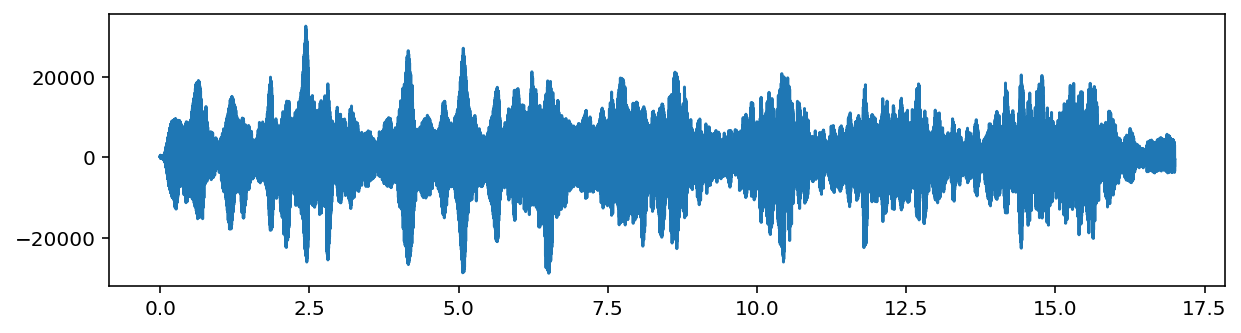

In [162]:
# Plot waveform
fig,ax = plt.subplots(figsize=(10,2.5))
passage = passage_extractor(audio,
        [ # List of onsets goes here
        ],
    [begin, end], # Segment between these seconds to plot
    sr=sample_rate
)[0]

# Function below plots only the content in the passage --- keep fixed
onset_visualizer(passage=passage, ax=ax)

### 2. Onset detection

In [163]:
# Link to tensorflow model
MODEL_PATH = "results/cnn-training-230205g/fold_0_tot-seq-32eps-lr0.0050-standard_model"
SPLIT_NAME = "sairfk-fk"

epoch = 32

with open("results/statistics/{}_mean.pickle".format(SPLIT_NAME), "rb") as f:
    mean = pickle.load(f)
with open("results/statistics/{}_std.pickle".format(SPLIT_NAME), "rb") as f:
    std = pickle.load(f)

print("number of folds in split: ", len(mean))

number of folds in split:  1


In [164]:
# Load model - detect onsets

model = tf.keras.models.load_model(MODEL_PATH, custom_objects = {"wbce": lambda x,y: None})
#model.load_weights(MODEL_PATH[:-6]+"_cp_{:04d}.ckpt".format(epoch))
cnn_input = get_segmented_data(audio, standard=True, mean=mean[0], std=std[0])
cnn_output = model.predict(cnn_input)
cnn_onsets = get_test_peaks(cnn_output, framerate)
print("Number of CNN onsets detected: ", len(cnn_onsets))

Number of CNN onsets detected:  77


In [86]:
# Detect HFC onsets

SHIFT = 5
THRES = 0.2
HOP = 441

sigg = madmom.audio.signal.SignalProcessor(num_channels=1)
frame = madmom.audio.signal.FramedSignalProcessor(frame_size=256, hop_size=HOP)
stft = madmom.audio.stft.STFTProcessor()
proc = madmom.processors.SequentialProcessor([sigg, frame, stft])

spect = proc(audio_fname)
hfc = madmom.features.onsets.high_frequency_content(np.abs(spect))
onehot, out = aubio_peakpicker_do(hfc, threshold=THRES)
hfc_onsets = (np.where(onehot==1)[0]-SHIFT)*HOP/sample_rate
print("Number of onsets detected: ", len(hfc_onsets))

/usr/local/lib/python3.9/site-packages/madmom/io/audio.py:493: WavFileWarning: Chunk (non-data) not understood, skipping it.
  file_sample_rate, signal = wavfile.read(filename, mmap=True)


Number of onsets detected:  261


In [154]:
# Evaluate the result (on the full recording)

pred_onsets = cnn_onsets

TOL = 0.025 # seconds of tolerance window
metrics = mir_eval.onset.evaluate(true_onsets, pred_onsets, window=TOL)
print("F-measure: ", metrics["F-measure"])
print("Precision: ", metrics["Precision"])
print("Recall: ", metrics["Recall"])

F-measure:  0.8755760368663594
Precision:  0.7786885245901639
Recall:  1.0


<AxesSubplot:>

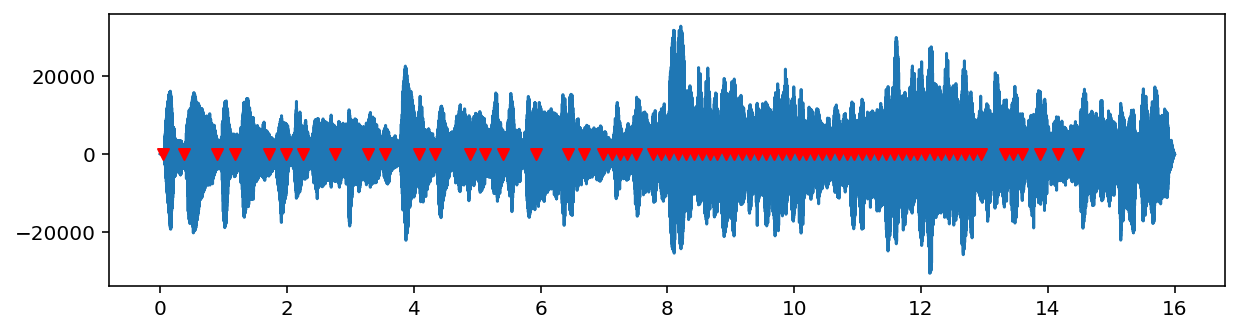

In [40]:
# Plot detections
pred_color = "red"
fig,ax = plt.subplots(figsize=(10,2.5))
passage = passage_extractor(audio,
        [ 
            pred_onsets      # added here
        ],
    [begin,end],
    sr=sample_rate
)[0]
onset_visualizer(passage=passage, ax=ax, onset_styles={"m":["v"], "c":[pred_color]})

<AxesSubplot:>

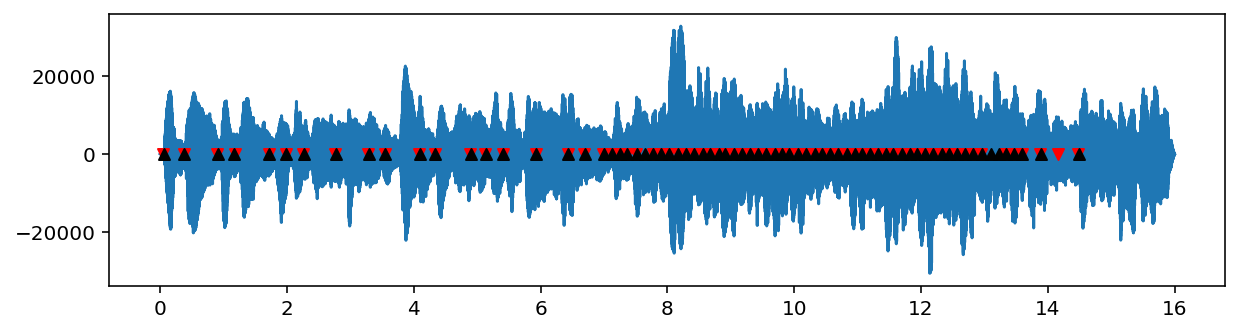

In [41]:
# Plot both detected and true onsets

true_color = "black"
fig,ax = plt.subplots(figsize=(10,2.5))
styles = {"m":["^", "v"], "c":[true_color, pred_color]}
passage = passage_extractor(audio,
        [ 
            true_onsets, 
            pred_onsets
        ],
    [begin, end], # Segment between these seconds to plot
    sr=sample_rate
)[0]
# Function below plots only the content in the passage
onset_visualizer(passage=passage, ax=ax, onset_styles=styles)

### 3. Note data

In [166]:
# Load and show note data 
# (ScoreCloud intermediate result)
#notes = pd.read_csv("datasets/sc_onsets/" + os.path.basename(audio_fname)[:-4] + ".midi.csv")
#notes = pd.read_csv("datasets/sturmbach/sturmbach_csv_raw/" + os.path.basename(audio_fname)[:-4] + ".csv")
notes = pd.read_csv("datasets/sturmbach/sturmbach_labels/" + os.path.basename(audio_fname)[:-4] + ".midi.csv")

# Remove polyphony for visualization
notes["prev_diff"] = np.concatenate(([np.inf],np.diff(notes["onset"])))
notes = notes[notes["prev_diff"] > 0]
notes[(notes["onset"]>begin) & (notes["offset"]<end)]

,onset,offset,pitch,note,octave,prev_diff
0,0.128000,0.395000,69,A,5,inf
1,0.488000,0.778000,62,D,5,0.360000
2,0.778000,1.103000,65,F,5,0.290000
3,1.057000,1.359000,69,A,5,0.279000
4,1.324000,1.626000,74,D,6,0.267000
...,...,...,...,...,...,...
81,14.536332,14.677523,62,D,5,0.092000
82,14.705780,14.983780,57,A,4,0.169448
83,14.983780,15.238593,74,D,6,0.278000
84,15.289154,15.539780,73,C#,6,0.305374


In [157]:
note_onsets = np.array(notes["onset"])
min_dists = []
for i,n in enumerate(note_onsets):
    if i>0 and i<len(note_onsets)-1:
        min_note_dist = np.min(np.abs(n-note_onsets[:i]))
        min_note_dist = np.min(np.abs(n-note_onsets[i+1:]))
        min_note_dist = 1
        min_dists.append( np.min(np.abs(pred_onsets-n))/min_note_dist)

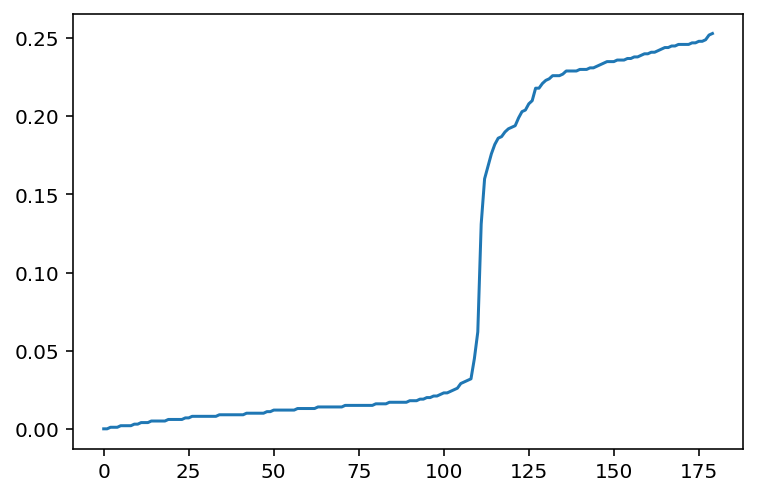

In [158]:
plt.plot(np.sort(min_dists))

In [167]:

shift = notes.iloc[0]["onset"] - pred_onsets[0]
shift = 0.07
print(shift)

0.07800000298023224


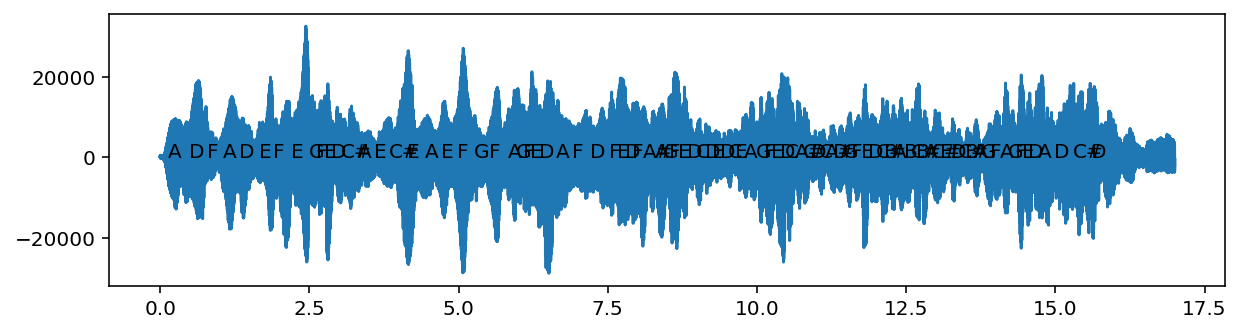

In [168]:
# Show note names in audio
fig,ax = plt.subplots(figsize=(10,2.5))
passage = passage_extractor(audio,
        [ # List of onsets goes here
        ],
    [begin, end], # Segment between these seconds to plot
    sr=sample_rate
)[0]

# Function below plots only the content in the passage --- keep fixed
onset_visualizer(passage=passage, ax=ax)

for note in notes.iloc:
    ax.annotate(text=note["note"], xy=(note["onset"],0))

In [116]:
vis_onsets = np.array([1.0])
fps = int(1/framerate)
n_steps = np.max(notes["offset"]*fps).astype(int)
pr_matrix = np.zeros((n_steps, 128)).astype(bool)
for i, note in enumerate(notes.iloc):
    pr_matrix[np.arange(int(note["onset"]*fps), int(note["offset"]*fps)), note["pitch"]] = True
pr = pr_matrix

In [169]:
vis_onsets = pred_onsets[(pred_onsets<end) & (pred_onsets>begin)] + shift

pr, classified_pr, onset_wins, art_idx = piano_roll_mat(
    notes, 
    vis_onsets, 
    fps=int(1/framerate), slur_tol=0.025
)

Text(0, 0.5, 'MIDI number')

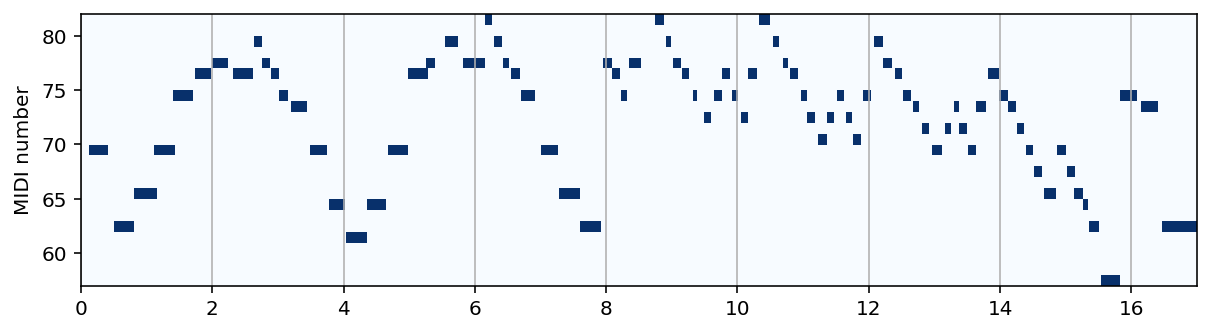

In [170]:
# Visualize as piano roll
FPS = int(1/framerate)
fig,ax = plt.subplots(figsize=(10,2.5))
ax.grid(axis='x')
ax.imshow(
    pr[int(begin*FPS):int(end*FPS), notes["pitch"].min():notes["pitch"].max()].transpose(),
    extent=(begin, end, notes["pitch"].min(),notes["pitch"].max()),
    aspect="auto", origin="lower", interpolation="None", cmap="Blues"
)
ax.set_ylabel("MIDI number")


In [28]:


# Convert list of notes to ABC score
note_seq = notes[(notes["prev_diff"]>0) & (notes["onset"]>begin) & (notes["offset"]<end)]
def tokenizer(r):
    t = r["note"].lower() if r["octave"]>=5 else r["note"].upper()
    t = t + "'" if r["octave"]==6 else t
    return t
token_seq = [tokenizer(r) for r in note_seq.iloc]


In [ ]:
# Show ABC score 

abc_str = """
X:1
T:{}
M:4/4
K:C
 {}
""".format(
    os.path.basename(audio_fname),
    " ".join(token_seq)
)
with open("test.abc", "w") as f:
    f.write(abc_str)

abc_score = converter.parse("test.abc")
abc_score.show()

In [35]:
abc_score = converter.parse("datasets/sturmbach/sturmbach_xmls/" + os.path.basename(audio_fname)[:-4] + ".abc")
abc_score

<music21.stream.Score 0x14c9fa2b0>

### 4. Extending score with slurs

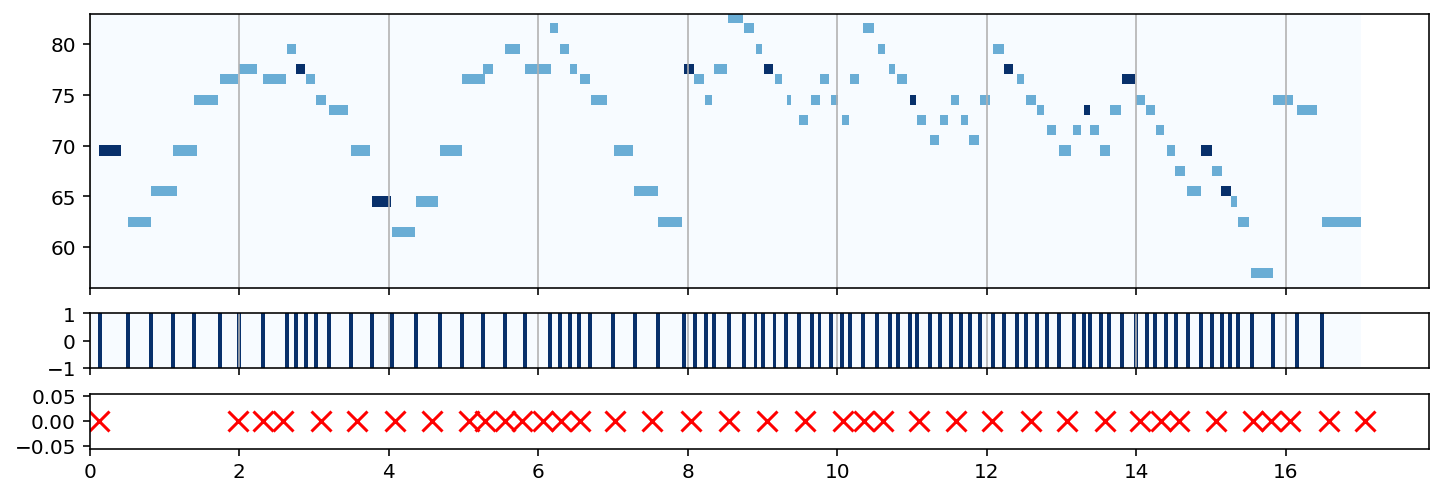

In [171]:
# Match hard onsets against note windows
# Classify notes (
#   articulated shown as dark, 
#   slurred shown as light blue
# )

ymin = np.where(pr==True)[1].min()-1
ymax = np.where(pr==True)[1].max()+1
fig, axs = plt.subplots(3,1,figsize=(12,4), sharex=True, gridspec_kw={'height_ratios': [5, 1, 1]})
#axs[0].text(x=1.1,y=65, s="Piano roll")
axs[0].grid(axis='x')
axs[0].imshow(
    classified_pr[int(begin*FPS):int(end*FPS), ymin:ymax].transpose(), 
    extent=(begin, end, ymin, ymax),
    aspect='auto', 
    origin="lower", 
    interpolation='none', 
    cmap='Blues'
)
#axs[1].text(x=1.1,y=0.0, s="Note onset window")
axs[1].grid(axis='x')
axs[1].imshow(
    onset_wins[int(begin*FPS):int(end*FPS), :].transpose(), 
    extent=(begin, end, -1, 1),
    aspect='auto', 
    origin="lower", 
    interpolation='none',
    cmap='Blues'
)
#axs[2].text(x=1.1,y=0.0, s="Hard onsets")
axs[2].scatter(
    vis_onsets, 
    np.zeros(len(vis_onsets)),
    marker="x",
    s=100,
    c="r"
)

In [172]:
# Extracting start- and end positions of slurs given articulated notes
sos = list(art_idx[np.where(np.diff(art_idx)>1)[0]])
eos = list(art_idx[1:][np.where(np.diff(art_idx)>1)[0]] - 1)
if len(notes)-1 not in art_idx:
    sos += [art_idx[-1]]
    eos += [len(notes)-1]
#slurred_token_seq = ["("+t if i in sos else (t+")" if i in eos else t) for i,t in enumerate(token_seq)]
print(sos)
print(eos)

[0, 9, 14, 30, 37, 50, 59, 66, 70, 77, 79]
[8, 13, 29, 36, 49, 58, 65, 69, 76, 78, 85]


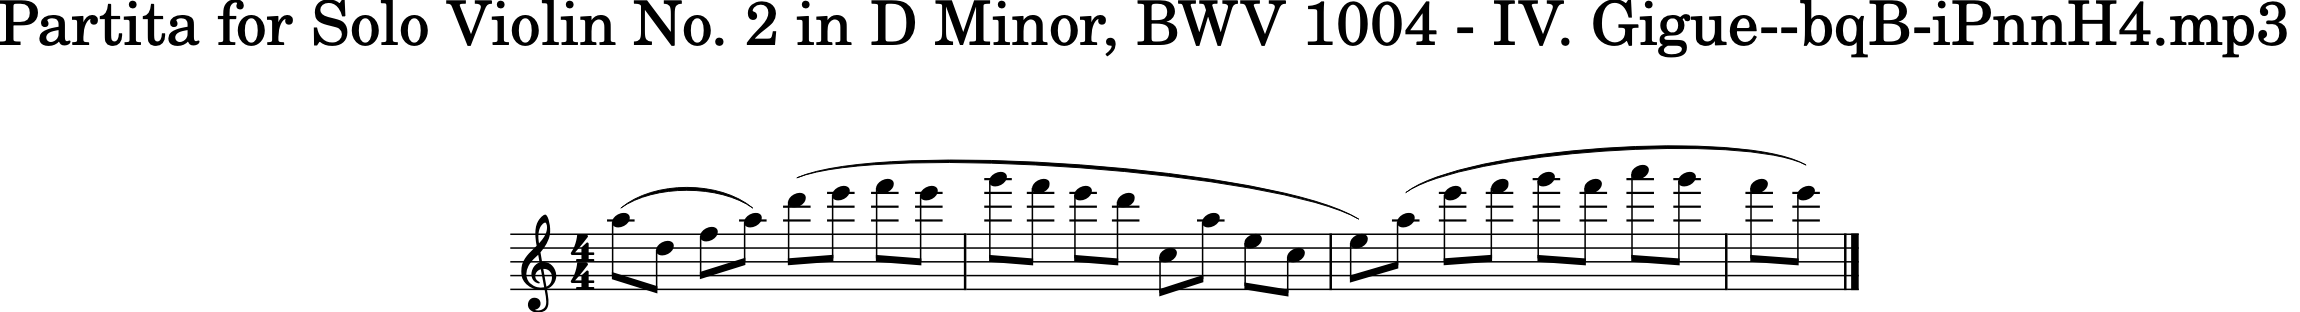

In [32]:
# Finally, show score with slurs

abc_str = """
X:1
T:{}
M:4/4
K:C
 {}
""".format(
    os.path.basename(audio_fname),
    " ".join(slurred_token_seq)
)
with open("test.abc", "w") as f:
    f.write(abc_str)

abc_score = converter.parse("test.abc")
abc_score.show()


In [173]:
with open("datasets/sturmbach/sturmbach_xmls/" + os.path.basename(audio_fname)[:-4] + ".abc", "r") as f:
    s = f.read()

print(s)

X:1
T:gigue_saraovinge.wav
L:1/16
Q:1/4=108
M:3/8
I:linebreak $
K:F
V:1 treble 
V:1
 z2 z2 A2 | (D2 F2) A2 | d2 (e2 f2) | e2 (gf ed) | (^c2 A2) E2 | (^C2 E2) A2 | (e2 f2) g2 | %7
 f2 (ag fe) | (d2 A2) F2 | D2 fe df | ba gf ed | cd ed ce | ag fe dc | Bc dc Bd | gf ed ^c=B | %15
 A=B ^cB Ac | ed ^c=B AG | FA (GF ED) | A,2 d2 ^c2 | D2 z2 z2 | %20




In [174]:
pre = "".join(re.split(r'(V\:)\d+', s)[0:2]) + " "
s = re.split(r'V\:\d+', s)[-1]

s = s.replace("(", "")
s = s.replace(")", "")
s = s.replace("| ", "")
s = re.sub(r"\s\%\d+\n", "", s)

print(pre)
print(s)

X:1
T:gigue_saraovinge.wav
L:1/16
Q:1/4=108
M:3/8
I:linebreak $
K:F
V: 

 z2 z2 A2 D2 F2 A2 d2 e2 f2 e2 gf ed ^c2 A2 E2 ^C2 E2 A2 e2 f2 g2 f2 ag fe d2 A2 F2 D2 fe df ba gf ed cd ed ce ag fe dc Bc dc Bd gf ed ^c=B A=B ^cB Ac ed ^c=B AG FA GF ED A,2 d2 ^c2 D2 z2 z2



In [175]:
p0 = re.split(r'([\^\=\_]*[A|B|C|D|E|F|G|a|b|c|d|e|f|g])', s)[0]
ps = re.split(r'([\^\=\_]*[A|B|C|D|E|F|G|a|b|c|d|e|f|g])', s)[1:-1]
pn = re.split(r'([\^\=\_]*[A|B|C|D|E|F|G|a|b|c|d|e|f|g])', s)[-1]
ps.append(pn.split(" ")[0] + " ")
pn = " ".join(pn.split(" ")[1:])
print(p0)
print(ps)
print(len(ps)/2)
print(pn)


 z2 z2 
['A', '2 ', 'D', '2 ', 'F', '2 ', 'A', '2 ', 'd', '2 ', 'e', '2 ', 'f', '2 ', 'e', '2 ', 'g', '', 'f', ' ', 'e', '', 'd', ' ', '^c', '2 ', 'A', '2 ', 'E', '2 ', '^C', '2 ', 'E', '2 ', 'A', '2 ', 'e', '2 ', 'f', '2 ', 'g', '2 ', 'f', '2 ', 'a', '', 'g', ' ', 'f', '', 'e', ' ', 'd', '2 ', 'A', '2 ', 'F', '2 ', 'D', '2 ', 'f', '', 'e', ' ', 'd', '', 'f', ' ', 'b', '', 'a', ' ', 'g', '', 'f', ' ', 'e', '', 'd', ' ', 'c', '', 'd', ' ', 'e', '', 'd', ' ', 'c', '', 'e', ' ', 'a', '', 'g', ' ', 'f', '', 'e', ' ', 'd', '', 'c', ' ', 'B', '', 'c', ' ', 'd', '', 'c', ' ', 'B', '', 'd', ' ', 'g', '', 'f', ' ', 'e', '', 'd', ' ', '^c', '', '=B', ' ', 'A', '', '=B', ' ', '^c', '', 'B', ' ', 'A', '', 'c', ' ', 'e', '', 'd', ' ', '^c', '', '=B', ' ', 'A', '', 'G', ' ', 'F', '', 'A', ' ', 'G', '', 'F', ' ', 'E', '', 'D', ' ', 'A', ',2 ', 'd', '2 ', '^c', '2 ', 'D', '2 ']
86.0
z2 z2



In [176]:
pp = ""
for n in range(int(len(ps)/2)):
    start = "(" if n in sos else ""
    end = ")" if n in eos else ""
    if ps[2*n+1] and ps[2*n+1][-1] == " ":
        end += " "
        ps[2*n+1] = ps[2*n+1][:-1]
    pp += start + ps[2*n] + ps[2*n+1] + end

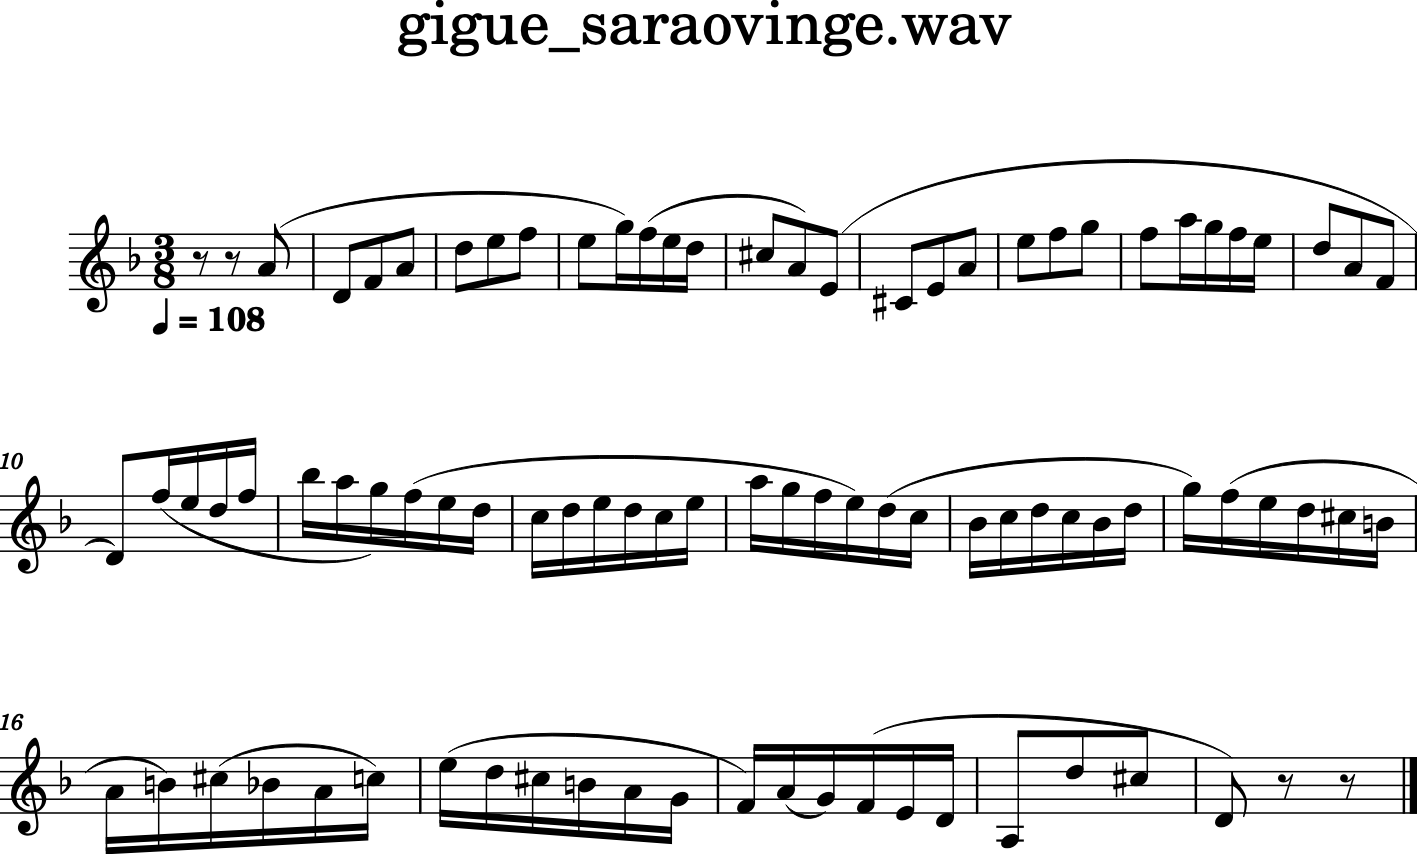

In [177]:
with open("test.abc", "w") as f:
    f.write(pre+p0+pp+pn)

abc_score = converter.parse("test.abc")
abc_score.show()

In [192]:
time_sig = 3
bars_per_line = 6

note_seq = (p0+pp+pn).strip().split(" ")
out_seq = ""
for i, token in enumerate(note_seq):
    
    if i%time_sig==0 and i>0:
        out_seq += "| "
    if i%(bars_per_line*time_sig)==0 and i>0:
        out_seq += "%" + str(i//time_sig) + "\n"
    out_seq += token
    out_seq += " "

print(pre+out_seq + "| %20")

X:1
T:Gigue_4.wav
L:1/16
Q:1/8=259
M:3/8
I:linebreak $
K:F
V: z2 z2 (A2 | D2 F2) A2 | (d2 e2 f2 | e2 gf ed | ^c2 A2 E2 | ^C2 E2) (A2 | %6
e2 f2) g2 | (f2 ag fe | d2 A2 F2 | D2 fe df | ba gf ed | cd ed ce | %12
ag fe dc | Bc dc Bd | gf ed ^c=B | A=B ^cB Ac | ed ^c=B AG | FA GF ED | %18
A,2 d2 ^c2 | D2) z2 z2 | %20


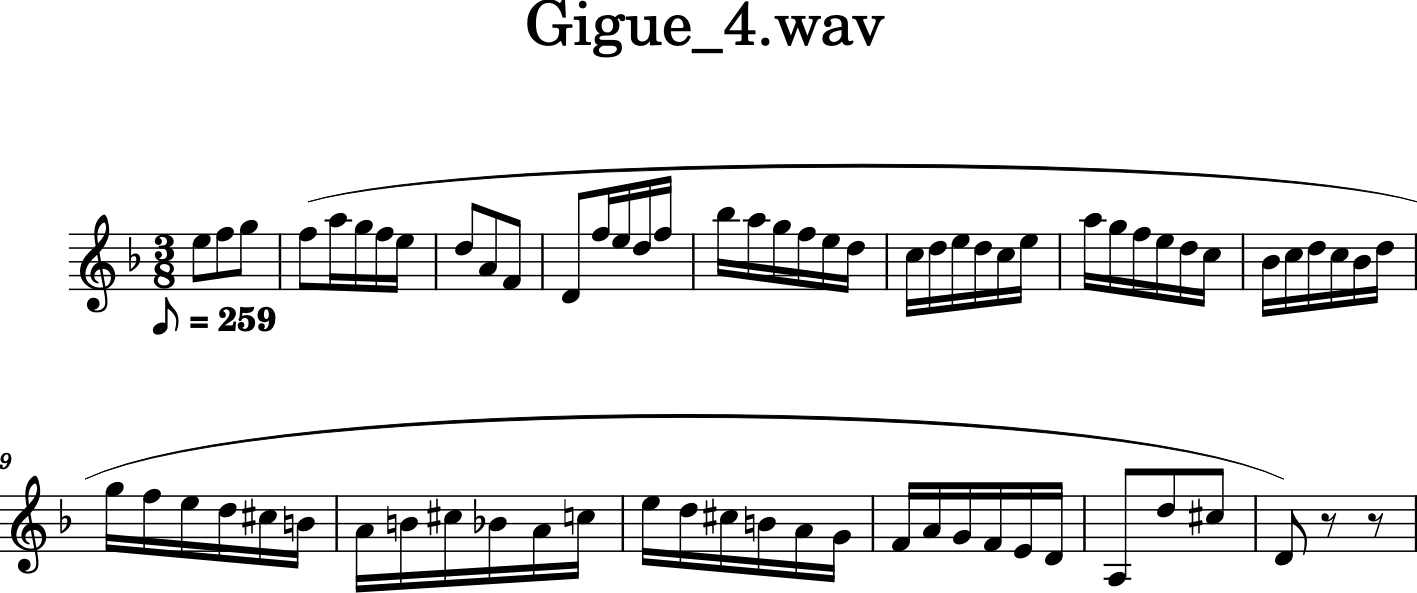

In [193]:
with open("test.abc", "w") as f:
    f.write(pre+out_seq+ "| %20")

abc_score = converter.parse("test.abc")
abc_score.show()

In [168]:
!python3 abc2xml.py "test.abc" > "test.xml"

-- decoded from utf-8
-- skipped header: (field X,1)
-- skipped I-field: linebreak $
-- done in 0.47 secs
